### Activation of necessary modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

#### Setting plotting and display options

In [2]:
np.set_printoptions(precision = 3)

pd.set_option("display.float_format", lambda x: "%.6f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

In [3]:
%matplotlib inline

#### NLP libraries

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import csv


import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/derrick_fang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-12-14 20:36:11.878972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Libraries for processing news headlines

In [5]:
from lxml import etree

import json

from io import StringIO
from os import listdir
from os.path import isfile, join
from copy import copy

from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize

#### Some additional libraries

In [6]:
import statsmodels.api as sm
import seaborn as sns
import datetime
from datetime import date

import zipfile
import os.path
import sys

In [7]:
import warnings
warnings.filterwarnings("ignore")

### Processing News Data

In [8]:
def ParseJSON(json_data):
    XML = json_data["content"]
    
    TREE = etree.parse(StringIO(XML),
                       parser = etree.HTMLParser()
                      )
    
    HEADLINES = TREE.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(HEADLINES) == json_data["count"]
    
    MAIN_TICKERS = list(map(lambda x: x.replace("/symbol/", ""),
                            TREE.xpath("//div[contains(@class, 'media-left')]//a/@href")
                           )
                       )
    assert len(MAIN_TICKERS) == json_data["count"]
    
    FINAL_HEADLINES = ["".join(f.xpath('.//text()')
                              ) for f in TREE.xpath("//div[contains(@class, 'media-body')]/ul/li[i]")
                      ]
    if len(FINAL_HEADLINES) == 0:
        FINAL_HEADLINES = ["".join(f.xpath('.//text()')
                                  ) for f in TREE.xpath("//div[contains(@class, 'media-body')]"
                                                       )
                          ]
        FINAL_HEADLINES = [f.replace(h, '').split('\xa0')[0].strip() for f, h in zip(FINAL_HEADLINES, HEADLINES)
                          ]
    return MAIN_TICKERS, FINAL_HEADLINES

In [9]:
Data = None

Data_News = []

Ret = []

Ret_F = []

with zipfile.ZipFile("headlines.zip", "r") as z:
    for filename in z.namelist():
        
        try:
            with z.open(filename) as f:
                Data = f.read()
                json_data = json.loads(Data)
                
            if json_data.get("count", 0) > 10:
                
                MAIN_TICKERS, FINAL_HEADLINES = ParseJSON(json_data)
                if len(FINAL_HEADLINES) != json_data["count"]:
                    continue
            
                FILE_DATE = filename.split("/")[-1].replace(".json", "")
                FILE_DATE = date(int(FILE_DATE[:4]), int(FILE_DATE[5:7]), int(FILE_DATE[8:])
                                 )
                
                DF_Dict = {"ticker": MAIN_TICKERS,
                           "headlines": FINAL_HEADLINES,
                           "date": [FILE_DATE] * len(MAIN_TICKERS)
                          }
                
                DF_F = pd.DataFrame(DF_Dict)
                Data_News.append(DF_F)
        
        except:
            pass

In [10]:
Data_News = pd.concat(Data_News)
Data_News

,ticker,headlines,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02
...,...,...,...
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23


In [11]:
Data_News['date']=pd.to_datetime(Data_News['date'])
Data_News = Data_News[Data_News['date'].dt.year > 2014]
Data_News

,ticker,headlines,date
0,HFC,HollyFrontier (NYSE:HFC) -1.6%,2015-01-02
1,,Gainers: VXX +8.39%. GDXJ +6.44%. GDX +3.84%. ...,2015-01-02
2,DDAY,"Viggle (VGGL +25.4%), a maker of Android/iOS a...",2015-01-02
3,JD,Though Baidu has sold off and Alibaba is near ...,2015-01-02
4,SIMO,NAND flash controller/4G transceiver vendor Si...,2015-01-02
...,...,...,...
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23


### Processing Stock Data

In [12]:
Data_News['ticker'].unique()

array(['HFC', '', 'DDAY', ..., 'VSBN', 'DEAC', 'WAAS'], dtype=object)

In [13]:
tickers = Data_News['ticker'].unique()
start = "2015-01-01"
end = "2019-12-31"

In [14]:
DF_stock_return = pd.DataFrame

for ticker in tickers:
    ticker_YF = yf.Ticker(ticker)
    
    if DF_stock_return.empty:
        DF_stock_return = ticker_YF.history(start = start,
                                            end = end)
        DF_stock_return["ticker"] = ticker

    else:
        temporary_data = ticker_YF.history(start = start,
                                           end = end)
        temporary_data["ticker"] = ticker
        DF_stock_return = DF_stock_return.append(temporary_data)
        
DF_stock_return

- HFC: No data found, symbol may be delisted
- : No data found for this date range, symbol may be delisted
- DDAY: No data found for this date range, symbol may be delisted
- LOCK: No data found for this date range, symbol may be delisted
- NBL: No data found, symbol may be delisted
- SFUN: No data found, symbol may be delisted
- ROAN: No data found, symbol may be delisted
- NRXGQ: No data found for this date range, symbol may be delisted
- CUR: No data found, symbol may be delisted
- NDRM: No data found for this date range, symbol may be delisted
- HNR: No data found for this date range, symbol may be delisted
- XOOM: No data found for this date range, symbol may be delisted
- OAS: No data found, symbol may be delisted
- DNR: No data found, symbol may be delisted
- CEL: No data found, symbol may be delisted
- SKUL: No data found for this date range, symbol may be delisted
- INFA: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- CNAT: No data found, symbol may be d

- BV-OLD: No data found, symbol may be delisted
- CSOD: No data found, symbol may be delisted
- TCPTF: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- GFIG: No data found for this date range, symbol may be delisted
- RKUS: No data found for this date range, symbol may be delisted
- MBLY: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- SCOK: No data found for this date range, symbol may be delisted
- PLCM: No data found for this date range, symbol may be delisted
- LF: No data found for this date range, symbol may be delisted
- MXIM: No data found, symbol may be delisted
- CY: No data found, symbol may be delisted
- MCPIQ: No data found for this date range, symbol may be delisted
- AVP: No data found, symbol may be delisted
- OIBR.C: No data found, symbol may be delisted
- CSLT: No data found, symbol may be delisted
- CYN: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- XXIA: No data found for this date range, symbol may 

- SQBG: No data found, symbol may be delisted
- ROYT: No data found, symbol may be delisted
- CHFS: No data found, symbol may be delisted
- KONA: No data found, symbol may be delisted
- ATRS: No data found, symbol may be delisted
- HTZ: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- PGHEF: No data found, symbol may be delisted
- UNXL: No data found for this date range, symbol may be delisted
- CXO: No data found, symbol may be delisted
- AUTO: No data found, symbol may be delisted
- OVTI: No data found for this date range, symbol may be delisted
- SREV: No data found, symbol may be delisted
- MENT: No data found for this date range, symbol may be delisted
- ESV: No data found, symbol may be delisted
- WNR: No data found for this date range, symbol may be delisted
- FIG: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- NEWM: No data found, symbol may be delisted
- RGDX: No data found for this date range, symbol may be delisted
- AZSEY: No data

- PVG: No data found, symbol may be delisted
- BLKIB: No data found for this date range, symbol may be delisted
- PPP: No data found for this date range, symbol may be delisted
- MY: No data found for this date range, symbol may be delisted
- RPRX: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- CTXS: No data found, symbol may be delisted
- FWM: No data found for this date range, symbol may be delisted
- BMR: No data found for this date range, symbol may be delisted
- DNKN: No data found, symbol may be delisted
- SYMC: No data found, symbol may be delisted
- LO: No data found for this date range, symbol may be delisted
- CDR: No data found, symbol may be delisted
- CSG: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- GIMO: No data found for this date range, symbol may be delisted
- EXL: No data found for this date range, symbol may be delisted
- DATA: No data found, symbol may be delisted
- MDCO: No data found, symbol may be delisted
- GPOR: 

- AST: No data found, symbol may be delisted
- TUES: No data found, symbol may be delisted
- PBY-OLD: No data found, symbol may be delisted
- ESES: No data found, symbol may be delisted
- POWR: No data found for this date range, symbol may be delisted
- UN: No data found, symbol may be delisted
- MJN: No data found for this date range, symbol may be delisted
- BAMM: No data found for this date range, symbol may be delisted
- AXPW: No data found for this date range, symbol may be delisted
- NORD: No data found for this date range, symbol may be delisted
- PVAC: No data found, symbol may be delisted
- KEM: No data found, symbol may be delisted
- VER: No data found, symbol may be delisted
- BT: No data found, symbol may be delisted
- VASC: No data found for this date range, symbol may be delisted
- EXAM: No data found for this date range, symbol may be delisted
- THOR-OLD: No data found, symbol may be delisted
- VPCO: No data found for this date range, symbol may be delisted
- BSTC: No da

- AWSM: No data found, symbol may be delisted
- FGP: No data found, symbol may be delisted
- RVLT: No data found, symbol may be delisted
- PEIX: No data found, symbol may be delisted
- SMRT: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- CAS: No data found, symbol may be delisted
- PSTR: No data found for this date range, symbol may be delisted
- SC: No data found, symbol may be delisted
- SAFM: No data found, symbol may be delisted
- ANFGY: No data found for this date range, symbol may be delisted
- VTAE: No data found for this date range, symbol may be delisted
- ATLS: No data found, symbol may be delisted
- OSIR: No data found, symbol may be delisted
- SPN: No data found, symbol may be delisted
- AIPT: No data found, symbol may be delisted
- ALO: No data found, symbol may be delisted
- NDRO-OLD: No data found, symbol may be delisted
- CRR: No data found, symbol may be delisted
- DAKP: No data found for this date range, symbol may be delisted
- PIH: No data fou

- BID: No data found, symbol may be delisted
- FI: No data found, symbol may be delisted
- PCMI: No data found, symbol may be delisted
- INXN: No data found, symbol may be delisted
- ELGX: No data found, symbol may be delisted
- MTOR: No data found, symbol may be delisted
- RRD: No data found, symbol may be delisted
- ISNS: No data found, symbol may be delisted
- RLOC: No data found for this date range, symbol may be delisted
- HCP: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- ARRY: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- ACIA: No data found, symbol may be delisted
- PX: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- MSLI: No data found for this date range, symbol may be delisted
- OBCI: No data found, symbol may be delisted
- PSG: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- WIMHF: No data found, symbol may be delisted
- STVVY: No data found, symbol may be delisted
- ANCUF: No data f

- ALQA: No data found, symbol may be delisted
- ROX: No data found, symbol may be delisted
- PEUGF: No data found, symbol may be delisted
- FSIC-OLD: No data found, symbol may be delisted
- WIFI: No data found, symbol may be delisted
- TIG: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- PCOM: No data found, symbol may be delisted
- TVIAQ: No data found for this date range, symbol may be delisted
- HIIQ: No data found, symbol may be delisted
- RDUS: No data found, symbol may be delisted
- XAN: No data found, symbol may be delisted
- CBR: No data found for this date range, symbol may be delisted
- FTD: No data found, symbol may be delisted
- CVRS: No data found, symbol may be delisted
- DGSE: No data found, symbol may be delisted
- JBS: No data found for this date range, symbol may be delisted
- CLBS: No data found, symbol may be delisted
- GEMP: No data found, symbol may be delisted
- VLRX: No data found, symbol may be delisted
- EXFO: No data found, symbol may be

- RLOG: No data found for this date range, symbol may be delisted
- DOVA: No data found, symbol may be delisted
- WAIR: No data found, symbol may be delisted
- RYB: No data found, symbol may be delisted
- INNV: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- TAT: No data found, symbol may be delisted
- ALTKY: No data found, symbol may be delisted
- CMTA: No data found, symbol may be delisted
- TNTR-OLD: No data found, symbol may be delisted
- COINB: No data found, symbol may be delisted
- CFX: No data found, symbol may be delisted
- LIXXF: No data found, symbol may be delisted
- SVON: No data found for this date range, symbol may be delisted
- CIFS: No data found, symbol may be delisted
- XLRN: No data found, symbol may be delisted
- LBCC: No data found, symbol may be delisted
- BOMN: No data found, symbol may be delisted
- ARNI: No data found, symbol may be delisted
- MPGR: No data found, symbol may be delisted
- LINU-OLD: No data found, symbol may be delisted
- 

- BXG: No data found, symbol may be delisted
- GSB: No data found, symbol may be delisted
- BCOM: No data found, symbol may be delisted
- OGLDF: No data found, symbol may be delisted
- RAVN: No data found, symbol may be delisted
- CMFN: No data found, symbol may be delisted
- ATV: No data found, symbol may be delisted
- WYND: No data found, symbol may be delisted
- ZEAL: No data found, symbol may be delisted
- MSON: No data found, symbol may be delisted
- ABAC-OLD: No data found, symbol may be delisted
- JP: No data found, symbol may be delisted
- RNKLF: No data found, symbol may be delisted
- PGLC: No data found, symbol may be delisted
- SMTX: No data found, symbol may be delisted
- MLNT: No data found, symbol may be delisted
- TLTZY: Data doesn't exist for startDate = 1420041600, endDate = 1577721600
- SNCT: No data found, symbol may be delisted
- NTGN: No data found, symbol may be delisted
- NITE: No data found, symbol may be delisted
- FCCY: No data found, symbol may be delisted
- 

- MLND: No data found, symbol may be delisted
- BTHCF: No data found, symbol may be delisted
- LVGO: No data found, symbol may be delisted
- CNST: No data found, symbol may be delisted
- MNCL: No data found, symbol may be delisted
- VIAC: No data found, symbol may be delisted
- GV: No data found, symbol may be delisted
- CCCL: No data found, symbol may be delisted
- VSBN: No data found, symbol may be delisted
- DEAC: No data found, symbol may be delisted
- WAAS: No data found, symbol may be delisted


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj Close
Date,,,,,,,,,
2014-12-31,22.726600,22.902171,22.287675,22.570538,5262600.000000,0.000000,0.000000,JD,NaN
2015-01-02,22.794879,23.516668,22.580292,23.428883,3358500.000000,0.000000,0.000000,JD,NaN
2015-01-05,23.428883,24.335997,23.409375,23.975101,5029600.000000,0.000000,0.000000,JD,NaN
2015-01-06,23.994610,24.394520,23.555683,23.926332,9797800.000000,0.000000,0.000000,JD,NaN
2015-01-07,24.248211,24.472550,23.965346,24.199440,9084400.000000,0.000000,0.000000,JD,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-23,4.970000,5.100000,4.310000,4.450000,1144964.000000,0.000000,0.000000,MITO,NaN
2019-12-24,4.590000,4.590000,3.920000,4.040000,733793.000000,0.000000,0.000000,MITO,NaN
2019-12-26,4.000000,4.017200,3.500000,3.560000,752515.000000,0.000000,0.000000,MITO,NaN


In [15]:
len(Data_News['ticker'].unique())

5116

In [16]:
DF_stock_return

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj Close
Date,,,,,,,,,
2014-12-31,22.726600,22.902171,22.287675,22.570538,5262600.000000,0.000000,0.000000,JD,NaN
2015-01-02,22.794879,23.516668,22.580292,23.428883,3358500.000000,0.000000,0.000000,JD,NaN
2015-01-05,23.428883,24.335997,23.409375,23.975101,5029600.000000,0.000000,0.000000,JD,NaN
2015-01-06,23.994610,24.394520,23.555683,23.926332,9797800.000000,0.000000,0.000000,JD,NaN
2015-01-07,24.248211,24.472550,23.965346,24.199440,9084400.000000,0.000000,0.000000,JD,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-23,4.970000,5.100000,4.310000,4.450000,1144964.000000,0.000000,0.000000,MITO,NaN
2019-12-24,4.590000,4.590000,3.920000,4.040000,733793.000000,0.000000,0.000000,MITO,NaN
2019-12-26,4.000000,4.017200,3.500000,3.560000,752515.000000,0.000000,0.000000,MITO,NaN


### Event Return

$ EventReturn_1 =  R_{t-1} + R_t + R_{t+1} $

$ EventReturn_2 =  R_{t-3} + R_{t-2} + R_{t-1} + R_t + R_{t+1} + R_{t+2} + R_{t+3} $

$ EventReturn_3 =  R_{t-1} + R_t $

$ EventReturn_4 =  R_t + R_{t+1} $

$ EventReturn_5 =  R_t + R_{t+1} + R_{t+2} $

$ EventReturn_6 =  R_t + R_{t+1} + R_{t+2} + R_{t+3} $

$ EventReturn_7 =  R_t + R_{t+1} + R_{t+2} + R_{t+3} + R_{t+4} $

In [17]:
FF = pd.read_csv('Daily-Fama-French.csv')
FF['Date']=pd.to_datetime(FF['Date'])
FF

,Date,Excess Return on the Market,Small-Minus-Big Return,High-Minus-Low Return,Risk-Free Return Rate (One Month Treasury Bill Rate),Momentum
0,1960-01-04,-0.000300,0.006000,0.007000,0.000170,-0.007900
1,1960-01-05,0.007800,-0.004100,0.005400,0.000170,-0.004700
2,1960-01-06,-0.004700,0.001300,0.003800,0.000170,0.000700
3,1960-01-07,-0.006500,0.003700,0.000900,0.000170,-0.002900
4,1960-01-08,-0.003300,0.001800,0.001000,0.000170,-0.004300
...,...,...,...,...,...,...
15811,2022-10-25,0.017800,0.013500,-0.015200,0.000110,-0.029100
15812,2022-10-26,-0.006600,0.004200,0.008900,0.000110,0.005200
15813,2022-10-27,-0.005400,0.003200,0.010600,0.000110,0.005200
15814,2022-10-28,0.023300,-0.000400,-0.003400,0.000110,0.000700


In [18]:
DF_stock_return = pd.merge(DF_stock_return.reset_index(), FF ,how = "left",
                           left_on=['Date'], right_on=['Date'])
DF_stock_return

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj Close,Excess Return on the Market,Small-Minus-Big Return,High-Minus-Low Return,Risk-Free Return Rate (One Month Treasury Bill Rate),Momentum
0,2014-12-31,22.726600,22.902171,22.287675,22.570538,5262600.000000,0.000000,0.000000,JD,NaN,-0.009300,0.005100,-0.004000,0.000000,-0.004800
1,2015-01-02,22.794879,23.516668,22.580292,23.428883,3358500.000000,0.000000,0.000000,JD,NaN,-0.001200,-0.006100,0.000800,0.000000,-0.000800
2,2015-01-05,23.428883,24.335997,23.409375,23.975101,5029600.000000,0.000000,0.000000,JD,NaN,-0.018400,0.003300,-0.006800,0.000000,0.011600
3,2015-01-06,23.994610,24.394520,23.555683,23.926332,9797800.000000,0.000000,0.000000,JD,NaN,-0.010400,-0.007800,-0.003100,0.000000,0.005100
4,2015-01-07,24.248211,24.472550,23.965346,24.199440,9084400.000000,0.000000,0.000000,JD,NaN,0.011900,0.002000,-0.006600,0.000000,0.009000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007160,2019-12-23,4.970000,5.100000,4.310000,4.450000,1144964.000000,0.000000,0.000000,MITO,NaN,0.001000,0.002000,-0.003400,0.000070,-0.006900
4007161,2019-12-24,4.590000,4.590000,3.920000,4.040000,733793.000000,0.000000,0.000000,MITO,NaN,0.000100,0.003900,-0.000100,0.000070,0.001600
4007162,2019-12-26,4.000000,4.017200,3.500000,3.560000,752515.000000,0.000000,0.000000,MITO,NaN,0.004800,-0.005400,0.000000,0.000070,0.003000
4007163,2019-12-27,3.490000,3.690000,3.420000,3.450000,348784.000000,0.000000,0.000000,MITO,NaN,-0.001000,-0.005300,-0.000700,0.000070,0.003700


In [19]:
DF_stock_return["Return"] = DF_stock_return.groupby(['ticker'])["Close"].pct_change()


DF_stock_return["Excess_Return_RF"] = DF_stock_return["Return"] - \
                                      DF_stock_return["Risk-Free Return Rate (One Month Treasury Bill Rate)"]

DF_stock_return["Event_Return_1"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(-1) + \
                                    DF_stock_return["Excess_Return_RF"].shift(1)

DF_stock_return["Event_Return_2"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(-1) + \
                                    DF_stock_return["Excess_Return_RF"].shift(-2) + \
                                    DF_stock_return["Excess_Return_RF"].shift(-3) + \
                                    DF_stock_return["Excess_Return_RF"].shift(1) + \
                                    DF_stock_return["Excess_Return_RF"].shift(2) + \
                                    DF_stock_return["Excess_Return_RF"].shift(3)

DF_stock_return["Event_Return_3"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(-1)

DF_stock_return["Event_Return_4"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(1)

DF_stock_return["Event_Return_5"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(1) + \
                                    DF_stock_return["Excess_Return_RF"].shift(2)

DF_stock_return["Event_Return_6"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(1) + \
                                    DF_stock_return["Excess_Return_RF"].shift(2) + \
                                    DF_stock_return["Excess_Return_RF"].shift(3)

DF_stock_return["Event_Return_7"] = DF_stock_return["Excess_Return_RF"] + \
                                    DF_stock_return["Excess_Return_RF"].shift(1) + \
                                    DF_stock_return["Excess_Return_RF"].shift(2) + \
                                    DF_stock_return["Excess_Return_RF"].shift(3) + \
                                    DF_stock_return["Excess_Return_RF"].shift(4)

### Building combined dataset

In [20]:
Data_News

,ticker,headlines,date
0,HFC,HollyFrontier (NYSE:HFC) -1.6%,2015-01-02
1,,Gainers: VXX +8.39%. GDXJ +6.44%. GDX +3.84%. ...,2015-01-02
2,DDAY,"Viggle (VGGL +25.4%), a maker of Android/iOS a...",2015-01-02
3,JD,Though Baidu has sold off and Alibaba is near ...,2015-01-02
4,SIMO,NAND flash controller/4G transceiver vendor Si...,2015-01-02
...,...,...,...
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23


In [21]:
Combined_DF = pd.merge(Data_News, DF_stock_return,
                       how = "left",
                       left_on = ["date", "ticker"],
                       right_on = ["Date", "ticker"]
                       )

Combined_DF

,ticker,headlines,date,Date,Open,High,Low,Close,Volume,Dividends,...,Momentum,Return,Excess_Return_RF,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7
0,HFC,HollyFrontier (NYSE:HFC) -1.6%,2015-01-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,Gainers: VXX +8.39%. GDXJ +6.44%. GDX +3.84%. ...,2015-01-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DDAY,"Viggle (VGGL +25.4%), a maker of Android/iOS a...",2015-01-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JD,Though Baidu has sold off and Alibaba is near ...,2015-01-02,2015-01-02,22.794879,23.516668,22.580292,23.428883,3358500.000000,0.000000,...,-0.000800,0.038029,0.038029,NaN,NaN,0.061343,NaN,NaN,NaN,NaN
4,SIMO,NAND flash controller/4G transceiver vendor Si...,2015-01-02,2015-01-02,19.772810,21.220004,19.615685,21.104229,563300.000000,0.000000,...,-0.000800,0.079070,0.079070,NaN,NaN,0.115120,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38464,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38465,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,2019-12-23,136.990005,138.520004,129.699997,135.580002,4186900.000000,0.000000,...,-0.006900,0.074582,0.074512,0.071794,-0.009690,0.065001,0.081305,0.070889,0.033928,0.005192
38466,,Wall Street futures are starting a holiday-sho...,2019-12-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38467,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,2019-12-23,18.093048,18.235513,17.710174,18.217705,597400.000000,0.000000,...,-0.006900,0.035425,0.035355,0.034632,0.043681,0.037729,0.032258,0.036240,0.043313,0.024716


In [22]:
Data_DF = Combined_DF[["ticker", "headlines", "date", "Event_Return_1",'Event_Return_2',
                       'Event_Return_3','Event_Return_4','Event_Return_5','Event_Return_6', 'Event_Return_7', 
                       'Excess_Return_RF', 'Return', "Close"]]

Data_DF = Data_DF.dropna()

Data_DF

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,Excess_Return_RF,Return,Close
197,SBLK,Star Bulk Carriers (NASDAQ:SBLK) -18% AH after...,2015-01-08,-0.153808,-0.203726,-0.155458,0.077433,0.116884,0.069498,0.002425,0.075783,0.075783,22.735415
199,TCS,On account of its FQ3 performance and a strong...,2015-01-08,0.001037,-0.097632,-0.099613,0.143422,0.152156,0.097460,0.110529,0.042773,0.042773,19.826738
201,FIVE,Five Below (NASDAQ:FIVE) -15%,2015-01-08,-0.113083,-0.160063,-0.164422,0.080592,0.077378,0.090654,0.068367,0.029252,0.029252,43.630001
202,BBEPQ,Breitburn Energy Partners (BBEP) -3.7%,2015-01-08,-0.056871,-0.318755,-0.027885,-0.017045,-0.005315,-0.111475,-0.021475,0.011940,0.011940,5.977907
205,BBBY,Bed Bath & Beyond's (NASDAQ:BBBY) comparable s...,2015-01-08,-0.014754,-0.030860,-0.051609,0.052710,0.047173,0.035704,0.043056,0.015855,0.015855,69.271492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38461,GBTC,Technicians were looking for another leg down ...,2019-12-23,0.048770,0.071450,-0.003293,0.065506,0.067812,0.118928,0.087419,0.013444,0.013514,9.000000
38463,ROK,JPMorgan has downgraded Rockwell Automation (N...,2019-12-23,-0.000157,-0.003579,-0.007531,0.007060,0.002035,0.003095,-0.000840,-0.000315,-0.000245,193.716949
38465,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,0.071794,-0.009690,0.065001,0.081305,0.070889,0.033928,0.005192,0.074512,0.074582,135.580002
38467,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,0.034632,0.043681,0.037729,0.032258,0.036240,0.043313,0.024716,0.035355,0.035425,18.217705


In [23]:
Data_DF.dropna().to_csv(r"NEWS_RETURN.csv", sep = "|", index = False)

In [24]:
Data_DF = pd.read_csv(r"NEWS_RETURN.csv", sep = "|")
Data_DF.dropna(inplace = True)
Data_DF

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,Excess_Return_RF,Return,Close
0,SBLK,Star Bulk Carriers (NASDAQ:SBLK) -18% AH after...,2015-01-08,-0.153808,-0.203726,-0.155458,0.077433,0.116884,0.069498,0.002425,0.075783,0.075783,22.735415
1,TCS,On account of its FQ3 performance and a strong...,2015-01-08,0.001037,-0.097632,-0.099613,0.143422,0.152156,0.097460,0.110529,0.042773,0.042773,19.826738
2,FIVE,Five Below (NASDAQ:FIVE) -15%,2015-01-08,-0.113083,-0.160063,-0.164422,0.080592,0.077378,0.090654,0.068367,0.029252,0.029252,43.630001
3,BBEPQ,Breitburn Energy Partners (BBEP) -3.7%,2015-01-08,-0.056871,-0.318755,-0.027885,-0.017045,-0.005315,-0.111475,-0.021475,0.011940,0.011940,5.977907
4,BBBY,Bed Bath & Beyond's (NASDAQ:BBBY) comparable s...,2015-01-08,-0.014754,-0.030860,-0.051609,0.052710,0.047173,0.035704,0.043056,0.015855,0.015855,69.271492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24587,GBTC,Technicians were looking for another leg down ...,2019-12-23,0.048770,0.071450,-0.003293,0.065506,0.067812,0.118928,0.087419,0.013444,0.013514,9.000000
24588,ROK,JPMorgan has downgraded Rockwell Automation (N...,2019-12-23,-0.000157,-0.003579,-0.007531,0.007060,0.002035,0.003095,-0.000840,-0.000315,-0.000245,193.716949
24589,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,0.071794,-0.009690,0.065001,0.081305,0.070889,0.033928,0.005192,0.074512,0.074582,135.580002
24590,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,0.034632,0.043681,0.037729,0.032258,0.036240,0.043313,0.024716,0.035355,0.035425,18.217705


In [25]:
len(Combined_DF['ticker'].unique())

5116

In [26]:
Data_DF.groupby(['ticker']).headlines.count()

ticker
A       11
AA      40
AAAP     1
AAL     37
AAME     1
        ..
ZUMZ    14
ZUO      8
ZYME     3
ZYNE    13
ZYXI     2
Name: headlines, Length: 3501, dtype: int64

<AxesSubplot: xlabel='headlines', ylabel='Count'>

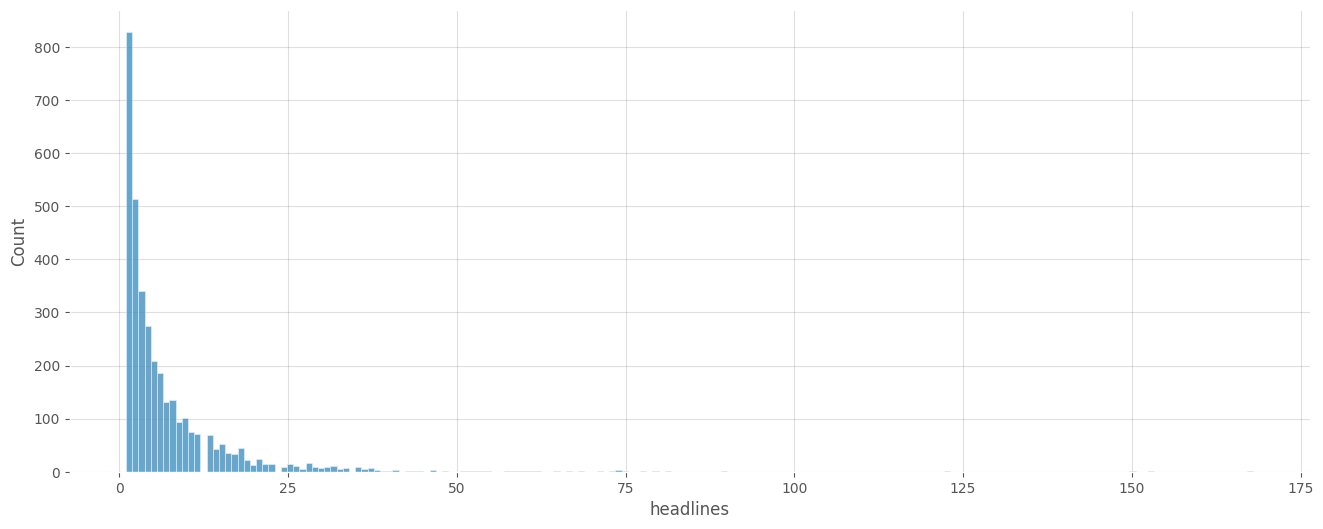

In [27]:
plt.figure(figsize = (16,6))
sns.histplot(data = Data_DF, x=Data_DF.groupby(['ticker']).headlines.count())

In [28]:
Data_DF.groupby(['ticker']).headlines.count().describe()

count   3501.000000
mean       7.023422
std       10.114743
min        1.000000
25%        2.000000
50%        4.000000
75%        9.000000
max      168.000000
Name: headlines, dtype: float64

### Natural Language Processing, Sentiment Analysis

In [29]:
SIA = SentimentIntensityAnalyzer()

In [30]:
stock_lexicon = pd.read_csv("lexicon.csv")

stock_lexicon["sentiment"] = (stock_lexicon["Aff_Score"] + stock_lexicon["Neg_Score"]
                             )/2

stock_lexicon

,Item,POS,Aff_Score,Neg_Score,sentiment
0,'em,PR,0.379542,0.533419,0.456481
1,'n,CC,1.413176,1.199917,1.306547
2,'n handle,NaN,2.839000,2.941000,2.890000
3,'s a,NaN,-0.023077,-0.013615,-0.018346
4,'s abc,NaN,2.261667,2.300000,2.280833
...,...,...,...,...,...
20545,zoom,VB,-0.652273,-0.649174,-0.650723
20546,zortrades.com,NN,2.141000,2.163000,2.152000
20547,zte,NN,4.934000,5.084000,5.009000
20548,zuck,NN,-0.237857,-0.185172,-0.211515


In [31]:
stock_lexicon = dict(zip(stock_lexicon.Item, 
                         stock_lexicon.sentiment)
                    )

stock_lexicon = {k:v for k, v in stock_lexicon.items() if len(k.split(" "))==1}

stock_lexicon_scaled = {}

for k, v in stock_lexicon.items():
    if v > 0:
        stock_lexicon_scaled[k] = v / max(stock_lexicon.values()
                                         ) * 4
        
    else:
        stock_lexicon_scaled[k] = v / min(stock_lexicon.values()
                                         ) * -4
        
final_lexicon = {}
final_lexicon.update(stock_lexicon_scaled)
final_lexicon.update(SIA.lexicon)
SIA.lexicon = final_lexicon

In [32]:
vader_sentiments = pd.np.array([SIA.polarity_scores(s)["compound"] for s in Data_DF["headlines"]
                               ]
                              )
Data_DF["sent_lex"] = vader_sentiments
Data_DF

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,Excess_Return_RF,Return,Close,sent_lex
0,SBLK,Star Bulk Carriers (NASDAQ:SBLK) -18% AH after...,2015-01-08,-0.153808,-0.203726,-0.155458,0.077433,0.116884,0.069498,0.002425,0.075783,0.075783,22.735415,0.866700
1,TCS,On account of its FQ3 performance and a strong...,2015-01-08,0.001037,-0.097632,-0.099613,0.143422,0.152156,0.097460,0.110529,0.042773,0.042773,19.826738,-0.524700
2,FIVE,Five Below (NASDAQ:FIVE) -15%,2015-01-08,-0.113083,-0.160063,-0.164422,0.080592,0.077378,0.090654,0.068367,0.029252,0.029252,43.630001,-0.122600
3,BBEPQ,Breitburn Energy Partners (BBEP) -3.7%,2015-01-08,-0.056871,-0.318755,-0.027885,-0.017045,-0.005315,-0.111475,-0.021475,0.011940,0.011940,5.977907,0.273200
4,BBBY,Bed Bath & Beyond's (NASDAQ:BBBY) comparable s...,2015-01-08,-0.014754,-0.030860,-0.051609,0.052710,0.047173,0.035704,0.043056,0.015855,0.015855,69.271492,0.840500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24587,GBTC,Technicians were looking for another leg down ...,2019-12-23,0.048770,0.071450,-0.003293,0.065506,0.067812,0.118928,0.087419,0.013444,0.013514,9.000000,0.575200
24588,ROK,JPMorgan has downgraded Rockwell Automation (N...,2019-12-23,-0.000157,-0.003579,-0.007531,0.007060,0.002035,0.003095,-0.000840,-0.000315,-0.000245,193.716949,0.653700
24589,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,0.071794,-0.009690,0.065001,0.081305,0.070889,0.033928,0.005192,0.074512,0.074582,135.580002,0.149700
24590,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,0.034632,0.043681,0.037729,0.032258,0.036240,0.043313,0.024716,0.035355,0.035425,18.217705,0.769700


In [33]:
Data_DF = Data_DF[["ticker", "headlines", "date", "Event_Return_1",'Event_Return_2',
                       'Event_Return_3','Event_Return_4','Event_Return_5','Event_Return_6', 
                   'Event_Return_7', "sent_lex"]]

Data_DF = Data_DF.dropna()

Data_DF

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,sent_lex
0,SBLK,Star Bulk Carriers (NASDAQ:SBLK) -18% AH after...,2015-01-08,-0.153808,-0.203726,-0.155458,0.077433,0.116884,0.069498,0.002425,0.866700
1,TCS,On account of its FQ3 performance and a strong...,2015-01-08,0.001037,-0.097632,-0.099613,0.143422,0.152156,0.097460,0.110529,-0.524700
2,FIVE,Five Below (NASDAQ:FIVE) -15%,2015-01-08,-0.113083,-0.160063,-0.164422,0.080592,0.077378,0.090654,0.068367,-0.122600
3,BBEPQ,Breitburn Energy Partners (BBEP) -3.7%,2015-01-08,-0.056871,-0.318755,-0.027885,-0.017045,-0.005315,-0.111475,-0.021475,0.273200
4,BBBY,Bed Bath & Beyond's (NASDAQ:BBBY) comparable s...,2015-01-08,-0.014754,-0.030860,-0.051609,0.052710,0.047173,0.035704,0.043056,0.840500
...,...,...,...,...,...,...,...,...,...,...,...
24587,GBTC,Technicians were looking for another leg down ...,2019-12-23,0.048770,0.071450,-0.003293,0.065506,0.067812,0.118928,0.087419,0.575200
24588,ROK,JPMorgan has downgraded Rockwell Automation (N...,2019-12-23,-0.000157,-0.003579,-0.007531,0.007060,0.002035,0.003095,-0.000840,0.653700
24589,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,0.071794,-0.009690,0.065001,0.081305,0.070889,0.033928,0.005192,0.149700
24590,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,0.034632,0.043681,0.037729,0.032258,0.036240,0.043313,0.024716,0.769700


<AxesSubplot: xlabel='sent_lex', ylabel='Count'>

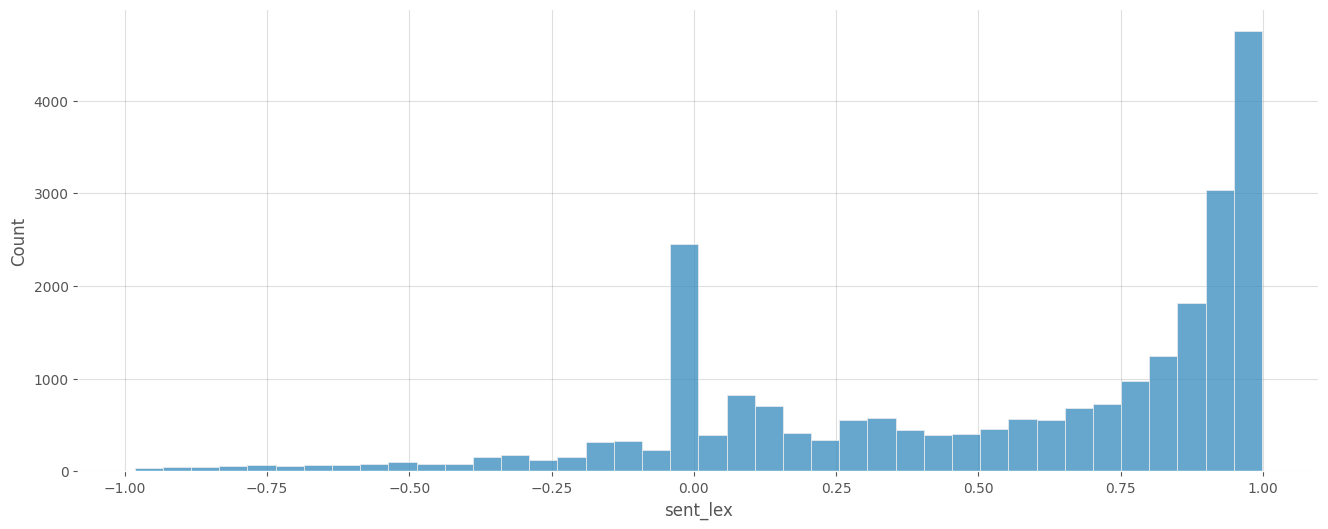

In [34]:
plt.figure(figsize = (16,6))
sns.histplot(data = Data_DF, x='sent_lex', bins = 40)

In [35]:
Pos_News = Data_DF[Data_DF['sent_lex'] > 0]
Pos_News

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,sent_lex
0,SBLK,Star Bulk Carriers (NASDAQ:SBLK) -18% AH after...,2015-01-08,-0.153808,-0.203726,-0.155458,0.077433,0.116884,0.069498,0.002425,0.866700
3,BBEPQ,Breitburn Energy Partners (BBEP) -3.7%,2015-01-08,-0.056871,-0.318755,-0.027885,-0.017045,-0.005315,-0.111475,-0.021475,0.273200
4,BBBY,Bed Bath & Beyond's (NASDAQ:BBBY) comparable s...,2015-01-08,-0.014754,-0.030860,-0.051609,0.052710,0.047173,0.035704,0.043056,0.840500
5,MU,"Hit hard on Tuesday amid a market rout, chip s...",2015-01-08,0.021326,-0.115198,0.044752,0.025484,-0.001455,-0.029369,-0.036795,0.622900
6,M,Macy's (NYSE:M) reports holiday sales rose 2.7...,2015-01-08,0.016969,-0.000385,-0.024023,0.044841,0.041157,0.032631,0.031719,0.934000
...,...,...,...,...,...,...,...,...,...,...,...
24587,GBTC,Technicians were looking for another leg down ...,2019-12-23,0.048770,0.071450,-0.003293,0.065506,0.067812,0.118928,0.087419,0.575200
24588,ROK,JPMorgan has downgraded Rockwell Automation (N...,2019-12-23,-0.000157,-0.003579,-0.007531,0.007060,0.002035,0.003095,-0.000840,0.653700
24589,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,0.071794,-0.009690,0.065001,0.081305,0.070889,0.033928,0.005192,0.149700
24590,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,0.034632,0.043681,0.037729,0.032258,0.036240,0.043313,0.024716,0.769700


In [36]:
Neg_News = Data_DF[Data_DF['sent_lex'] < 0]
Neg_News

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,sent_lex
1,TCS,On account of its FQ3 performance and a strong...,2015-01-08,0.001037,-0.097632,-0.099613,0.143422,0.152156,0.097460,0.110529,-0.524700
2,FIVE,Five Below (NASDAQ:FIVE) -15%,2015-01-08,-0.113083,-0.160063,-0.164422,0.080592,0.077378,0.090654,0.068367,-0.122600
29,AETUF,ARC,2015-01-08,-0.054277,-0.176918,-0.057328,-0.042587,-0.072202,-0.148774,-0.139110,-0.057000
31,INFI,Infinity Pharmaceuticals (NASDAQ:INFI) is off,2015-01-08,-0.076328,-0.084715,-0.091876,-0.106314,-0.143440,-0.166832,-0.154398,-0.057900
40,ALBO,Thinly-traded nano cap Biodel (BIOD) is up,2015-01-08,0.092248,0.097210,0.099097,0.151771,0.172750,0.201527,0.246640,-0.179900
...,...,...,...,...,...,...,...,...,...,...,...
24526,CAG,ConAgra Brands (NYSE:CAG): Q2 Non-GAAP EPS of ...,2019-12-19,0.195575,0.194578,0.200441,0.153756,0.167227,0.181957,0.187200,-0.125000
24542,BA,Boeing (BA -1.4%) slips to its lowest levels o...,2019-12-20,0.020942,0.009187,0.012484,-0.008104,0.003080,0.003010,-0.039996,-0.361500
24552,MITO,Nasdaq has suspended trading in Stealth BioThe...,2019-12-20,-0.662806,-0.735082,-0.716583,-0.599579,-0.492323,-0.460768,-0.467810,-0.386200
24558,BB,BlackBerry (NYSE:BB) +5.7% reports Q3 beats wi...,2019-12-20,0.142844,0.124313,0.114596,0.152103,0.141525,0.139707,0.150237,-0.343000


In [37]:
Neu_News = Data_DF[Data_DF['sent_lex'] == 0]
Neu_News

,ticker,headlines,date,Event_Return_1,Event_Return_2,Event_Return_3,Event_Return_4,Event_Return_5,Event_Return_6,Event_Return_7,sent_lex
34,NBIX,Neurocrine Biosciences (NASDAQ:NBIX) jumps,2015-01-08,0.351175,0.311947,0.285418,0.321699,0.281045,0.217997,0.240379,0.000000
41,HCA,HCA +2.6%,2015-01-09,-0.009978,-0.017634,-0.036557,0.022842,0.040976,0.039305,0.010104,0.000000
50,MDU,MDU,2015-01-09,-0.023895,-0.009772,-0.048285,-0.026924,-0.010249,-0.012808,-0.036132,0.000000
60,AYI,Acuity Brands (NYSE:AYI) reports,2015-01-09,0.112382,0.103072,0.077396,0.101887,0.119616,0.107090,0.083069,0.000000
61,AGEN,Agenus (NASDAQ:AGEN) jumps,2015-01-09,0.478394,0.346146,0.453456,0.312042,0.337618,0.275268,0.323006,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
24537,KEY,KeyCorp (NYSE:KEY),2019-12-20,-0.003092,0.012525,0.001409,0.004331,0.001805,0.014167,0.016589,0.000000
24568,MYGN,Myriad Genetics (NASDAQ:MYGN),2019-12-23,0.015431,0.005891,0.008519,-0.087683,-0.070937,-0.075471,-0.038104,0.000000
24579,TBPH,Theravance Biopharma (NASDAQ:TBPH),2019-12-23,0.053721,0.128577,0.065604,0.014016,0.057295,0.092876,0.093247,0.000000
24581,LCI,Lannett (NYSE:LCI),2019-12-23,-0.005631,-0.057542,-0.006656,-0.009986,-0.007860,-0.011213,-0.013466,0.000000


In [38]:
len(Pos_News) / len(Data_DF)

0.8141852047663589

In [39]:
len(Neg_News) / len(Data_DF)

0.1081784537801456

In [40]:
len(Neu_News) / len(Data_DF)

0.07763634145349546

In [41]:
Pos_News.dropna().to_csv(r"Pos_News.csv", sep = "|", index = False)
# Pos_News = pd.read_csv(r"Pos_News.csv", sep = "|")

In [42]:
Neg_News.dropna().to_csv(r"Neg_News.csv", sep = "|", index = False)
# Neg_News = pd.read_csv(r"Neg_News.csv", sep = "|")

In [46]:
News_sent = Data_DF[["ticker", "headlines", "date", "sent_lex"]]
News_sent

,ticker,headlines,date,sent_lex
0,SBLK,Star Bulk Carriers (NASDAQ:SBLK) -18% AH after...,2015-01-08,0.866700
1,TCS,On account of its FQ3 performance and a strong...,2015-01-08,-0.524700
2,FIVE,Five Below (NASDAQ:FIVE) -15%,2015-01-08,-0.122600
3,BBEPQ,Breitburn Energy Partners (BBEP) -3.7%,2015-01-08,0.273200
4,BBBY,Bed Bath & Beyond's (NASDAQ:BBBY) comparable s...,2015-01-08,0.840500
...,...,...,...,...
24587,GBTC,Technicians were looking for another leg down ...,2019-12-23,0.575200
24588,ROK,JPMorgan has downgraded Rockwell Automation (N...,2019-12-23,0.653700
24589,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up,2019-12-23,0.149700
24590,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23,0.769700


#### VADER example

In [43]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/derrick_fang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
sentence = 'You are a good person.'
sentiment_dict = SIA.polarity_scores(sentence)
sentiment_dict

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [45]:
sentiment_compound = SIA.polarity_scores(sentence)["compound"]
sentiment_compound

0.4404